<a href="https://colab.research.google.com/github/nvinogradskaya/DL_HW4_RNN/blob/main/Contrastive_etalon_170users.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import uuid
import shutil
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, LayerNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MAX_USERS = 170
SEQ_LENGTH = 10
EMBEDDING_DIM = 16
LSTM_UNITS = 64
BATCH_SIZE = 128
EPOCHS = 10
TEST_SIZE = 0.3

DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Data/"
SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/contrastive_results-v3-2/"
SEQ_SAVE_PATH = os.path.join(SAVE_PATH, 'sequences/')
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)

Mounted at /content/drive


In [3]:
from tqdm import tqdm
def load_and_preprocess_data(data_path, max_users=MAX_USERS):
    data = []
    user_dirs = sorted(os.listdir(data_path))[:max_users]
    for user in tqdm(user_dirs, desc="Loading users"):
        traj_dir = os.path.join(data_path, user, 'Trajectory')
        traj_files = sorted([f for f in os.listdir(traj_dir) if f.endswith('.plt')])
        for traj_file in traj_files:
            df = pd.read_csv(
                os.path.join(traj_dir, traj_file),
                skiprows=6,
                header=None,
                usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )
            df['user'] = user
            data.append(df)

    df = pd.concat(data, ignore_index=True)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.sort_values(by=['user', 'datetime'], inplace=True)
    df = df[(df['lat'] != 0) & (df['lon'] != 0)].ffill()

    scaler = MinMaxScaler()
    df[['lat', 'lon', 'alt']] = scaler.fit_transform(df[['lat', 'lon', 'alt']])

    df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek / 7)

    user_ids = {user: idx for idx, user in enumerate(df['user'].unique())}
    df['user_id'] = df['user'].map(user_ids)

    return df, user_ids, scaler

In [4]:
df, user_ids, scaler = load_and_preprocess_data(DATA_PATH)

Loading users: 100%|██████████| 170/170 [1:02:23<00:00, 22.02s/it]


In [5]:
# генерация последовательностей
def create_sequences_and_save(df, user_ids, seq_length, test_size=0.3, save_path='./seq_data'):
    os.makedirs(save_path, exist_ok=True)
    features = ['lat', 'lon', 'alt', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    targets = ['lat', 'lon']

    for user, user_df in tqdm(df.groupby('user'), desc="Creating sequences"):
        uid = user_ids[user]
        user_df = user_df.reset_index(drop=True)
        split_idx = int(len(user_df) * (1 - test_size))
        if split_idx <= seq_length:
            continue

        def process_chunk(data, is_train=True):
            window_size = seq_length + 1
            data_values = data[features].values
            if len(data_values) < window_size:
                return
            X = np.lib.stride_tricks.sliding_window_view(data_values, (window_size, data_values.shape[1])).squeeze(axis=1)
            X = X[:, :-1]
            y = data[targets].values[seq_length:]
            chunk_size = 1000
            for i in range(0, len(X), chunk_size):
                save_chunk(X[i:i+chunk_size], y[i:i+chunk_size], is_train)

        def save_chunk(X, y, is_train):
            suffix = 'train' if is_train else 'test'
            chunk_id = uuid.uuid4().hex
            np.savez_compressed(
                os.path.join(save_path, f'user_{uid}_{suffix}_{chunk_id}.npz'),
                X=X,
                y=y,
                user_id=uid
            )

        process_chunk(user_df.iloc[:split_idx], is_train=True)
        process_chunk(user_df.iloc[split_idx-seq_length:], is_train=False)


In [6]:
shutil.rmtree(SEQ_SAVE_PATH, ignore_errors=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)
create_sequences_and_save(df, user_ids, SEQ_LENGTH, save_path=SEQ_SAVE_PATH)

Creating sequences: 100%|██████████| 170/170 [04:26<00:00,  1.57s/it]


In [7]:
def load_all_sequences_from_disk(save_path):
    X_train, X_test, y_train, y_test, users_train, users_test = [], [], [], [], [], []
    for fname in tqdm(sorted(os.listdir(save_path)), desc="Loading sequences"):
        if not fname.endswith('.npz'):
            continue
        split_type = 'train' if 'train' in fname else 'test'
        uid = int(fname.split('_')[1])
        data = np.load(os.path.join(save_path, fname))
        X, y = data['X'], data['y']
        if split_type == 'train':
            X_train.append(X); y_train.append(y); users_train.append(np.full(len(X), uid))
        else:
            X_test.append(X); y_test.append(y); users_test.append(np.full(len(X), uid))
    return (
        np.concatenate(X_train), np.concatenate(X_test),
        np.concatenate(y_train), np.concatenate(y_test),
        np.concatenate(users_train), np.concatenate(users_test)
    )

In [8]:
X_train, X_test, y_train, y_test, users_train, users_test = load_all_sequences_from_disk(SEQ_SAVE_PATH)

Loading sequences: 100%|██████████| 24790/24790 [04:11<00:00, 98.65it/s] 


In [9]:
def create_triplets(X, user_ids):
    anchors, positives, negatives = [], [], []
    for uid in tqdm(np.unique(user_ids), desc="Creating triplets"):
        same_user_idx = np.where(user_ids == uid)[0]
        diff_user_idx = np.where(user_ids != uid)[0]
        if len(same_user_idx) < 2:
            continue
        for i in range(min(len(same_user_idx) - 1, 100)):
            a_idx, p_idx = same_user_idx[i], same_user_idx[i+1]
            n_idx = np.random.choice(diff_user_idx)
            anchors.append(X[a_idx])
            positives.append(X[p_idx])
            negatives.append(X[n_idx])
    return np.array(anchors), np.array(positives), np.array(negatives)

In [10]:
anchors, positives, negatives = create_triplets(X_train, users_train)

Creating triplets: 100%|██████████| 170/170 [00:08<00:00, 20.79it/s]


In [11]:
def contrastive_model(input_shape, embedding_dim):
    inp = Input(shape=input_shape)
    x = LSTM(32)(inp)
    x = Dense(embedding_dim)(x)
    model = Model(inputs=inp, outputs=x)
    return model

def triplet_loss_fn(a, p, n, margin=1.0):
    ap_dist = tf.reduce_sum(tf.square(a - p), axis=1)
    an_dist = tf.reduce_sum(tf.square(a - n), axis=1)
    return tf.reduce_mean(tf.maximum(ap_dist - an_dist + margin, 0.0))

In [12]:
triplet_encoder = contrastive_model(X_train.shape[1:], EMBEDDING_DIM)
optimizer = tf.keras.optimizers.Adam(1e-3)

In [14]:
for epoch in range(10):
    with tf.GradientTape() as tape:
        emb_a = triplet_encoder(anchors)
        emb_p = triplet_encoder(positives)
        emb_n = triplet_encoder(negatives)
        loss = triplet_loss_fn(emb_a, emb_p, emb_n)
    grads = tape.gradient(loss, triplet_encoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, triplet_encoder.trainable_variables))
    print(f"сontrastive epoch {epoch+1} // loss = {loss.numpy():.4f}")

сontrastive epoch 1 // loss = 0.1834
сontrastive epoch 2 // loss = 0.1673
сontrastive epoch 3 // loss = 0.1533
сontrastive epoch 4 // loss = 0.1410
сontrastive epoch 5 // loss = 0.1304
сontrastive epoch 6 // loss = 0.1211
сontrastive epoch 7 // loss = 0.1130
сontrastive epoch 8 // loss = 0.1058
сontrastive epoch 9 // loss = 0.0996
сontrastive epoch 10 // loss = 0.0941


In [16]:
user_embeddings_matrix = {}
batch_size = 1024

for uid in np.unique(users_train):
    user_seqs = X_train[users_train == uid]
    user_embs = []

    for i in range(0, len(user_seqs), batch_size):
        batch = user_seqs[i:i+batch_size]
        batch_embs = triplet_encoder(batch)
        user_embs.append(batch_embs.numpy())

    user_embs = np.concatenate(user_embs, axis=0)
    user_embeddings_matrix[uid] = np.mean(user_embs, axis=0)

user_embeddings_train = np.array([user_embeddings_matrix[uid] for uid in users_train])
user_embeddings_test = np.array([user_embeddings_matrix[uid] for uid in users_test])

In [17]:
class CombinedDataGenerator(Sequence):
    def __init__(self, X, user_embeddings, y, batch_size=64):
        self.X = X
        self.user_embeddings = user_embeddings
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.X))

        X_batch = self.X[start:end]
        user_batch = self.user_embeddings[start:end]
        y_batch = self.y[start:end]

        return (X_batch, user_batch), y_batch

    def on_epoch_end(self):
        pass

In [18]:
def build_lstm_model(seq_input_shape, user_input_shape):

    seq_input = Input(shape=seq_input_shape, name='seq_input')
    x = LSTM(LSTM_UNITS, return_sequences=False)(seq_input)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    user_input = Input(shape=user_input_shape, name='user_input')
    user_dense = Dense(16, activation='relu')(user_input)

    combined = Concatenate()([x, user_dense])

    output = Dense(2, activation='linear')(combined)

    model = Model(inputs=[seq_input, user_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [19]:
train_gen = CombinedDataGenerator(X_train, user_embeddings_train, y_train, batch_size=BATCH_SIZE)
val_gen = CombinedDataGenerator(X_test, user_embeddings_test, y_test, batch_size=BATCH_SIZE)

seq_input_shape = (X_train.shape[1], X_train.shape[2])
user_input_shape = (EMBEDDING_DIM,)

model = build_lstm_model(seq_input_shape, user_input_shape)

In [20]:
callbacks = [
    ModelCheckpoint(os.path.join(SAVE_PATH, 'best_model.keras'), save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134655/134655 ━━━━━━━━━━━━━━━━━━━━ 836s 6ms/step - loss: 0.0059 - mae: 0.0198 - val_loss: 1.6621e-04 - val_mae: 0.0103
Epoch 2/10
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 840s 6ms/step - loss: 1.1039e-04 - mae: 0.0054 - val_loss: 1.1543e-04 - val_mae: 0.0077
Epoch 3/10
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 843s 6ms/step - loss: 1.0306e-04 - mae: 0.0047 - val_loss: 6.1472e-05 - val_mae: 0.0032
Epoch 4/10
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 845s 6ms/step - loss: 9.6127e-05 - mae: 0.0045 - val_loss: 3.2403e-05 - val_mae: 0.0024
Epoch 5/10
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 848s 6ms/step - loss: 7.4241e-05 - mae: 0.0035 - val_loss: 1.4987e-05 - val_mae: 0.0030
Epoch 6/10
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 850s 6ms/step - loss: 5.5678e-05 - mae: 0.0032 - val_loss: 4.9911e-06 - val_mae: 0.0013
Epoch 7/10
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 845s 6ms/step - loss: 5.0692e-05 - mae: 0.0030 - val_loss: 7.4197e-06 - val_mae: 0.0018
Epoch 8/10
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 853s 6ms/step - loss: 4.5384e-0

In [21]:
model.load_weights(os.path.join(SAVE_PATH, 'best_model.keras'))
def predict_with_generator(model, X, user_embs, batch_size=64, save_path=None, verbose=False, max_errors=3):
    generator = CombinedDataGenerator(
        X, user_embs, np.zeros((len(user_embs), 2)),
        batch_size=batch_size
    )

    preds = []
    error_count = 0
    suppressed = False

    for i, (X_batch, _) in enumerate(tqdm(generator, total=len(generator), desc="Predicting", disable=not verbose)):
        try:
            if X_batch[0].shape[0] == 0:
                continue

            batch_pred = model.predict(X_batch, verbose=0)
            preds.append(batch_pred)


        except Exception as e:
            if error_count < max_errors:
                print(f"err {i}: {e}")
            elif error_count == max_errors and not suppressed:
                print("err")
                suppressed = True
            error_count += 1
            continue

    if preds:
        result = np.vstack(preds)
        return result
    else:
        if verbose:
            print("nulls")
        return np.empty((0, 2))

In [22]:
#y_pred = predict_with_generator(model, X_test, user_embeddings_test, save_path=os.path.join(SAVE_PATH, "y_pred"))
dataset = tf.data.Dataset.from_tensor_slices(((X_test, user_embeddings_test), y_test))
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
y_pred = model.predict(dataset)

57716/57716 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step


In [23]:
def calculate_metrics(preds, targets):
    ade = np.mean(np.linalg.norm(preds - targets, axis=-1))
    fde = np.mean(np.linalg.norm(preds - targets, axis=-1))
    within_100m = np.mean(np.linalg.norm(preds - targets, axis=-1) < 0.001)  # 0.001 ≈ 100 meters
    return ade, fde, within_100m

ade, fde, acc_within_100m = calculate_metrics(y_pred, y_test)
print(f"ADE: {ade:.4f}, FDE: {fde:.4f}, % predictions < 100m: {acc_within_100m:.4f}")

ADE: 0.0011, FDE: 0.0011, % predictions < 100m: 0.7526


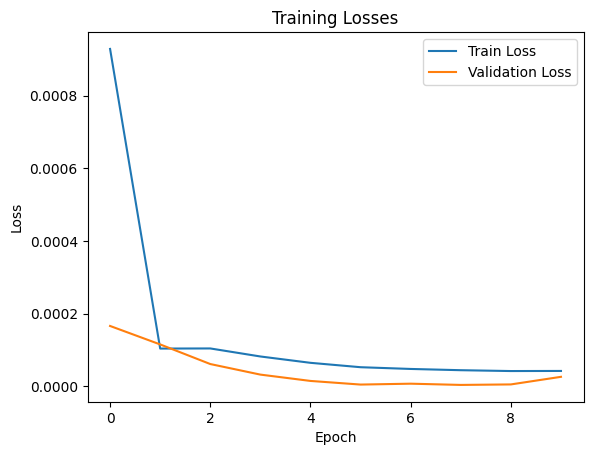

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()